In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from model import MultimodalRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tools import plot_loss_function, model_comparison
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import os
import json
%pip install optuna -q
import optuna
import pickle

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
Matplotlib is building the font cache; this may take a moment.


Note: you may need to restart the kernel to use updated packages.


In [2]:
def plot_r2(r2, experiment_name='regression') -> None:
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='R^2')         
    plt.title('R^2')
    plt.xlabel('Epochs')
    plt.ylabel('R^2')
    
    # saving
    os.makedirs(f'logs/{experiment_name}', exist_ok=True)
    plot_path = os.path.join(f"logs/{experiment_name}/", "loss.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### tab data

In [3]:
train = pd.read_csv("data/train_preprocessed.csv")
test = pd.read_csv("data/test_preprocessed.csv")

In [4]:
y_train = train['SalaryNormalized']
y_test = test['SalaryNormalized']
X_train_tab = train.drop(columns=['SalaryNormalized'])
X_test_tab = test.drop(columns=['SalaryNormalized'])

In [5]:
def cast_to_tensor(train, test):
    if isinstance(train, pd.DataFrame):
        train = train.values
    if isinstance(test, pd.DataFrame):
        test = test.values
    return torch.tensor(train, dtype=torch.float32), torch.tensor(test, dtype=torch.float32)

In [6]:
X_train_tab, X_test_tab = cast_to_tensor(X_train_tab, X_test_tab)
y_train, y_test = [t.unsqueeze(1) for t in cast_to_tensor(y_train, y_test)]

### text data

#### n-grams

In [7]:
# uni
X_train_text_uni = np.load("data/X_train_text_uni.npy", allow_pickle=True)
X_test_text_uni = np.load("data/X_test_text_uni.npy", allow_pickle=True)
X_train_text_uni, X_test_text_uni = cast_to_tensor(X_train_text_uni, X_test_text_uni)

#bi
X_train_text_bi = np.load("data/X_train_text_bi.npy", allow_pickle=True)
X_test_text_bi = np.load("data/X_test_text_bi.npy", allow_pickle=True)
X_train_text_bi, X_test_text_bi = cast_to_tensor(X_train_text_bi, X_test_text_bi)

#tri
X_train_text_tri = np.load("data/X_train_text_tri.npy", allow_pickle=True)
X_test_text_tri = np.load("data/X_test_text_tri.npy", allow_pickle=True)
X_train_text_tri, X_test_text_tri = cast_to_tensor(X_train_text_tri, X_test_text_tri)

#### word2vec

In [ ]:
with open('data/texts_w2v_train.pkl', 'rb') as file:
    X_train_text_w2c = pickle.load(file)

with open('data/texts_w2v_test.pkl', 'rb') as file:
    X_test_text_w2c = pickle.load(file)

X_train_text_w2c, X_test_text_w2c = cast_to_tensor(X_train_text_w2c, X_test_text_w2c)

#### roberta

In [21]:
X_train_text_roberta = pd.read_parquet('data/texts_roberta_train.parquet')
X_test_text_roberta = pd.read_parquet('data/texts_roberta_test.parquet')
X_train_text_roberta, X_test_text_roberta = cast_to_tensor(X_train_text_roberta, X_test_text_roberta)

Select text data

In [9]:
data = 'uni'

In [10]:
if data == 'uni':
    X_train_text = X_train_text_uni
    X_test_text = X_test_text_uni
if data == 'bi':
    X_train_text = X_train_text_bi
    X_test_text = X_test_text_bi
if data == 'tri':
    X_train_text = X_train_text_tri
    X_test_text = X_test_text_tri
if data == 'w2c':
    X_train_text = X_train_text_w2c
    X_test_text = X_test_text_w2c
if data == 'roberta':
    X_train_text = X_train_text_roberta
    X_test_text = X_test_text_roberta

## Training

In [11]:
def prepare_dataloaders(batch_size, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test):
    train_dataset = TensorDataset(X_train_text, X_train_tab, y_train)
    test_dataset = TensorDataset(X_test_text, X_test_tab, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [12]:
def train_evaluate(model, optimizer, criterion, epochs, train_loader, test_loader, results_path='logs/',  patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    history = {"train_loss": [], "test_loss": [], 'r2': []}

    best_loss = float("inf")
    best_r2 = -float("inf")
    patience_counter = 0 
    
    for epoch in range(epochs):
        train_loss = 0.0
        # -----------TRAIN-------------
        model.train()
        for text_batch, tab_batch, y_batch in train_loader:
            text_batch = text_batch.to(device)
            tab_batch = tab_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            preds = model(text_batch, tab_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_batch.size(0)
    
        avg_train_loss = train_loss / len(train_loader.dataset)

        # -----------EVALUATE-------------
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for text_batch, tab_batch, y_batch in test_loader:
                text_batch = text_batch.to(device)
                tab_batch = tab_batch.to(device)
                y_batch = y_batch.to(device)
            
                preds_test = model(text_batch, tab_batch)
                loss = criterion(preds_test, y_batch)

                test_loss += loss.item() * text_batch.size(0) 
                
                all_preds.append(preds_test.detach().cpu())
                all_targets.append(y_batch.detach().cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        avg_test_loss = test_loss / len(test_loader.dataset)
        r2 = r2_score(all_targets, all_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - test_loss: {avg_test_loss:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['r2'].append(r2)

        # early stopping
        if r2 > best_r2:
            best_r2 = r2
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    # saving results
    os.makedirs(results_path, exist_ok=True)
    file_path = os.path.join(results_path, 'results.json')
    
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=4)
        
    return best_r2, history

In [14]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1], dropout=0.4, hidden_dim=1024)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=6.45e-5, weight_decay=1e-4)
epochs = 30

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [42]:
train_loader, test_loader = prepare_dataloaders(64, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test)

Epoch 1/30 - test_loss: 0.4657
Epoch 2/30 - test_loss: 0.4752
Epoch 3/30 - test_loss: 0.4435
Epoch 4/30 - test_loss: 0.4280
Epoch 5/30 - test_loss: 0.4215
Epoch 6/30 - test_loss: 0.4226
Epoch 7/30 - test_loss: 0.4076
Epoch 8/30 - test_loss: 0.3992
Epoch 9/30 - test_loss: 0.4169
Epoch 10/30 - test_loss: 0.3965
Epoch 11/30 - test_loss: 0.3927
Epoch 12/30 - test_loss: 0.3874
Epoch 13/30 - test_loss: 0.3871
Epoch 14/30 - test_loss: 0.3852
Epoch 15/30 - test_loss: 0.3777
Epoch 16/30 - test_loss: 0.3772
Epoch 17/30 - test_loss: 0.3728
Epoch 18/30 - test_loss: 0.3789
Epoch 19/30 - test_loss: 0.3815
Epoch 20/30 - test_loss: 0.3695
Epoch 21/30 - test_loss: 0.3686
Epoch 22/30 - test_loss: 0.3636
Epoch 23/30 - test_loss: 0.3627
Epoch 24/30 - test_loss: 0.3654
Epoch 25/30 - test_loss: 0.3613
Epoch 26/30 - test_loss: 0.3609
Epoch 27/30 - test_loss: 0.3586
Epoch 28/30 - test_loss: 0.3584
Epoch 29/30 - test_loss: 0.3533
Epoch 30/30 - test_loss: 0.3548


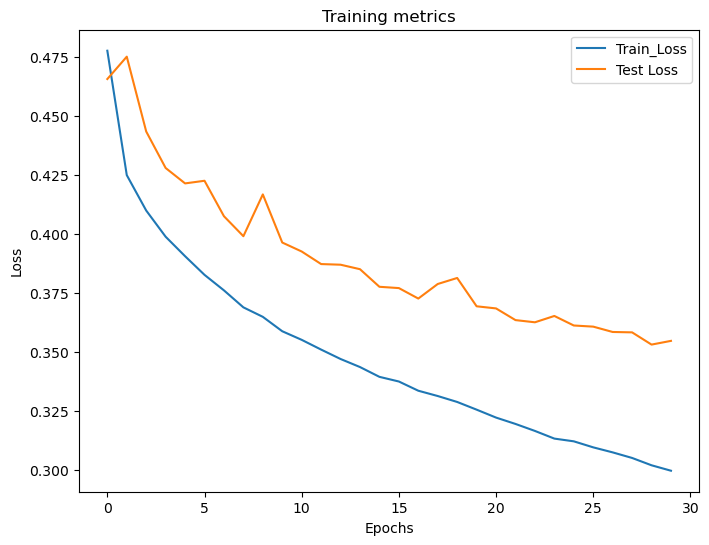

In [39]:
best_r2, history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, test_loader)
plot_loss_function(history['train_loss'], history['test_loss'], 'baseline')
print(history['r2'][-1])

Epoch 1/30 - test_loss: 0.4728
Epoch 2/30 - test_loss: 0.4515
Epoch 3/30 - test_loss: 0.4402
Epoch 4/30 - test_loss: 0.4455
Epoch 5/30 - test_loss: 0.4352
Epoch 6/30 - test_loss: 0.4455
Epoch 7/30 - test_loss: 0.4166
Epoch 8/30 - test_loss: 0.4129
Epoch 9/30 - test_loss: 0.4092
Epoch 10/30 - test_loss: 0.4036
Epoch 11/30 - test_loss: 0.4026
Epoch 12/30 - test_loss: 0.4001
Epoch 13/30 - test_loss: 0.3972
Epoch 14/30 - test_loss: 0.3959
Epoch 15/30 - test_loss: 0.4139
Epoch 16/30 - test_loss: 0.3938
Epoch 17/30 - test_loss: 0.4010
Epoch 18/30 - test_loss: 0.3881
Epoch 19/30 - test_loss: 0.3909
Epoch 20/30 - test_loss: 0.3836
Epoch 21/30 - test_loss: 0.3836
Epoch 22/30 - test_loss: 0.3830
Epoch 23/30 - test_loss: 0.3805
Epoch 24/30 - test_loss: 0.3848
Epoch 25/30 - test_loss: 0.3805
Epoch 26/30 - test_loss: 0.3764
Epoch 27/30 - test_loss: 0.3735
Epoch 28/30 - test_loss: 0.3970
Epoch 29/30 - test_loss: 0.3779
Epoch 30/30 - test_loss: 0.3831


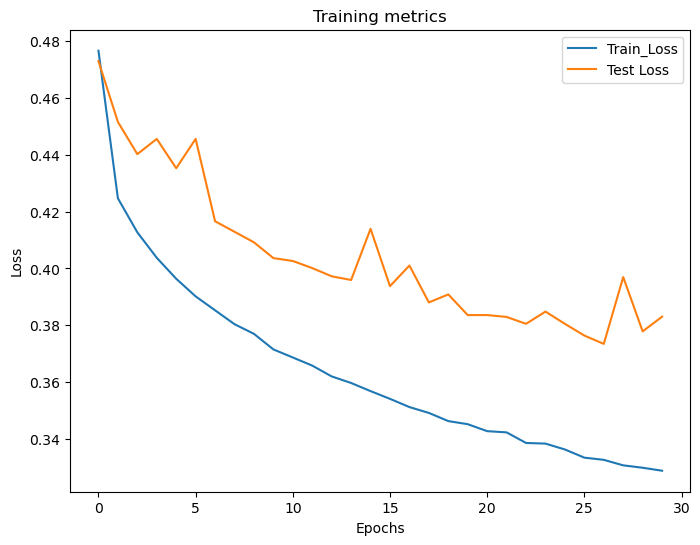

In [58]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1], dropout=0.35, hidden_dim=1024)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=6.45e-5, weight_decay=0.0003)
epochs = 30
best_r2, history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, test_loader)
plot_loss_function(history['train_loss'], history['test_loss'], 'baseline')

In [40]:
print(history['r2'][-1]) # no, droput=0.4

0.642210841178894


In [44]:
print(history['r2'][-1]) # 0.0001, droput=0.4

0.638209342956543


In [46]:
print(history['r2'][-1]) # 0.001, droput=0.4

0.6036807298660278


In [49]:
print(history['r2'][-1]) # 0.001, dropout 0.2

0.6138674020767212


In [51]:
print(history['r2'][-1]) # 0.0005, dropout 0.2

0.6240077018737793


In [53]:
print(history['r2'][-1]) # 0.0005, dropout 0.25

0.62018883228302


In [55]:
print(history['r2'][-1]) # 0.0001, dropout 0.3

0.6269866824150085


In [57]:
print(history['r2'][-1]) # 0.0001, dropout 0.35

0.6376784443855286


In [ ]:
print(history['r2'][-1]) # 0.0003, dropout 0.35

# Feature Selection - Information Gain (IG)

In [ ]:
X_test_combined = np.hstack([X_test_text, X_test_tab])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

In [ ]:
X_test_text_tensor = X_test_text.clone().detach().requires_grad_(True)
X_test_tab_tensor  = X_test_tab.clone().detach().requires_grad_(True)
y_test_tensor      = y_test.clone().detach()
X_test_text_tensor = X_test_text_tensor.to(device)
X_test_tab_tensor  = X_test_tab_tensor.to(device)
y_test_tensor      = y_test_tensor.to(device)

In [ ]:
ig = IntegratedGradients(model)

In [ ]:
batch_size = 64
attr_text_list = []
attr_tab_list = []

for i in range(0, X_test_text_tensor.shape[0], batch_size):
    X_text_batch = X_test_text_tensor[i:i+batch_size].to(device)
    X_tab_batch  = X_test_tab_tensor[i:i+batch_size].to(device)

    attr_text_batch, attr_tab_batch = ig.attribute(
        inputs=(X_text_batch, X_tab_batch),
        target=0,
        n_steps=20,
        return_convergence_delta=False
    )
    attr_text_list.append(attr_text_batch.detach().cpu())
    attr_tab_list.append(attr_tab_batch.detach().cpu())

attr_text = torch.cat(attr_text_list, dim=0)
attr_tab = torch.cat(attr_tab_list, dim=0)

In [ ]:
text_feature_names = [f"text_{i}" for i in range(X_train_text.shape[1])]
tab_feature_names = list((train.drop(columns=['SalaryNormalized'])).columns)
all_feature_names = text_feature_names + tab_feature_names

In [ ]:
attr_text_mean = attr_text.abs().mean(dim=0).detach().numpy()
attr_tab_mean = attr_tab.abs().mean(dim=0).detach().numpy()

feature_names = list(text_feature_names) + list(tab_feature_names)
importances = np.concatenate([attr_text_mean, attr_tab_mean])

In [ ]:
print("all features: ", len(feature_names))

In [ ]:
top_k = 25
sorted_idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature importance (Integrated Gradients)")
plt.title("Top Text and Tabular Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig(f'plots/{data}_TopTabularAndTextFeatures.png')
plt.show()
plt.close()

In [ ]:
# text
sorted_idx_text = np.argsort(attr_text_mean)[::-1][:20]
plt.barh(np.array(text_feature_names)[sorted_idx_text], attr_text_mean[sorted_idx_text])
plt.title("Top Text Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig(f'plots/{data}_TopTextFeatures.png')
plt.show()

# tab
sorted_idx_tab = np.argsort(attr_tab_mean)[::-1][:20]
plt.barh(np.array(tab_feature_names)[sorted_idx_tab], attr_tab_mean[sorted_idx_tab])
plt.title("Top Tabular Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig(f'plots/{data}_TopTabularFeatures.png')
plt.show()
plt.close()

# Prepare top 25 selected features

In [ ]:
selected_cols = np.array(feature_names)[sorted_idx]
selected_idx = [all_feature_names.index(col) for col in selected_cols]

In [ ]:
text_idx = [i for i, name in enumerate(text_feature_names) if name in selected_cols]
tab_idx = [i for i, name in enumerate(tab_feature_names) if name in selected_cols]

X_train_text_selected = X_train_text[:, text_idx]
X_test_text_selected  = X_test_text[:, text_idx]

X_train_tab_selected = X_train_tab[:, tab_idx]
X_test_tab_selected  = X_test_tab[:, tab_idx]

print("Selected text features:", X_train_text_selected.shape)
print("Selected tab features:", X_train_tab_selected.shape)

In [ ]:
model = MultimodalRegressor(text_dim=X_train_text_selected.shape[1], tab_dim=X_train_tab_selected.shape[1], dropout=0.3)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

# Model comparison

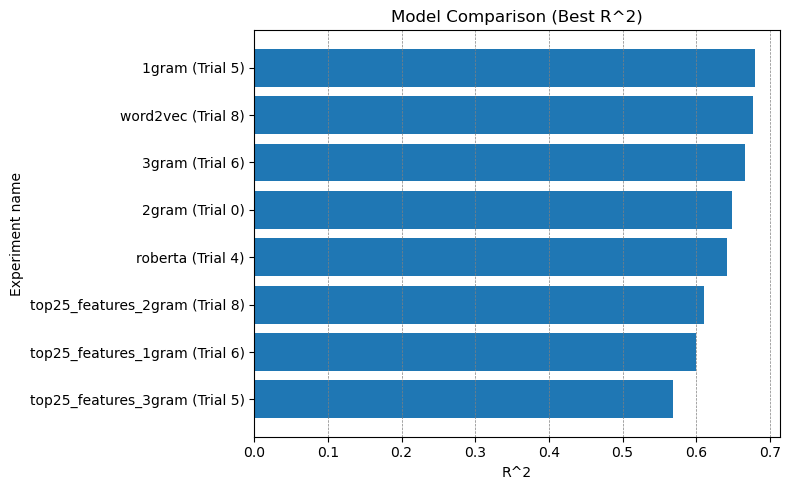

In [32]:
model_comparison()

# Optuna

In [30]:
def create_objective(X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test, exp_path, epochs):
    
    def objective(trial):
        
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.3, 0.5)
        hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512, 1024]) # 32, 64 (w2v, grams)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
        text_dim = X_train_text.shape[1]
        tab_dim = X_train_tab.shape[1] 
        
        model = MultimodalRegressor(
            text_dim=text_dim, 
            tab_dim=tab_dim, 
            dropout=dropout, 
            hidden_dim=hidden_dim
        )
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_func = nn.MSELoss()
        
        train_loader, test_loader = prepare_dataloaders(
            batch_size, X_train_text, X_train_tab, y_train, 
            X_test_text, X_test_tab, y_test
        )
    
        trial_name = f"trial_{trial.number}"
        results_path = os.path.join(exp_path, trial_name)
        
        best_test_r2, history = train_evaluate(
            model, optimizer, loss_func, epochs=epochs,
            train_loader=train_loader, test_loader=test_loader, 
            results_path=results_path, patience=5
        )
    
        trial.set_user_attr('history', history)
    
        return best_test_r2
    return objective

### selected features

In [ ]:
# exp_name = 'top25_features'
# exp_path = f'logs/{exp_name}/'

# objective_fn = create_objective(
#     X_train_text = X_train_text_selected,
#     X_train_tab = X_train_tab_selected, 
#     y_train = y_train,
#     X_test_text = X_test_text_selected, 
#     X_test_tab = X_test_tab_selected, 
#     y_test = y_test,
#     exp_path = exp_path,
#     epochs = 30
# )

# study = optuna.create_study(direction="maximize") 
# study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

# print("Best R2:", study.best_value)
# print("Best params:", study.best_params)


# # save best results
# best_trial_info = {
#     "trial_number": study.best_trial.number,
#     "best_r2": study.best_value,
#     "best_params": study.best_params
# }

# os.makedirs(exp_path, exist_ok=True)
# with open(os.path.join(exp_path, 'best_trail.json'), "w", encoding="utf-8") as f:
#     json.dump(best_trial_info, f, indent=4)

### all features

In [31]:
exp_name = 'roberta'
exp_path = f'logs/{exp_name}/'

objective_fn = create_objective(
    X_train_text = X_train_text,
    X_train_tab = X_train_tab, 
    y_train = y_train,
    X_test_text = X_test_text, 
    X_test_tab = X_test_tab, 
    y_test = y_test,
    exp_path = exp_path,
    epochs = 30
)

study = optuna.create_study(direction="maximize") 
study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

print("Best R2:", round(study.best_value, 3))
print("Best params:", study.best_params)


# save best results
best_trial_info = {
    "trial_number": study.best_trial.number,
    "best_r2": study.best_value,
    "best_params": study.best_params
}

os.makedirs(exp_path, exist_ok=True)
with open(os.path.join(exp_path, 'best_trial.json'), "w", encoding="utf-8") as f:
    json.dump(best_trial_info, f, indent=4)

[I 2025-10-24 10:13:59,134] A new study created in memory with name: no-name-0ba73f0e-535d-461a-8cf1-085919f80de4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30 - test_loss: 0.5908
Epoch 2/30 - test_loss: 0.5254
Epoch 3/30 - test_loss: 0.4986
Epoch 4/30 - test_loss: 0.4855
Epoch 5/30 - test_loss: 0.4744
Epoch 6/30 - test_loss: 0.4684
Epoch 7/30 - test_loss: 0.4631
Epoch 8/30 - test_loss: 0.4584
Epoch 9/30 - test_loss: 0.4558
Epoch 10/30 - test_loss: 0.4521
Epoch 11/30 - test_loss: 0.4495
Epoch 12/30 - test_loss: 0.4464
Epoch 13/30 - test_loss: 0.4444
Epoch 14/30 - test_loss: 0.4426
Epoch 15/30 - test_loss: 0.4397
Epoch 16/30 - test_loss: 0.4371
Epoch 17/30 - test_loss: 0.4358
Epoch 18/30 - test_loss: 0.4354
Epoch 19/30 - test_loss: 0.4323
Epoch 20/30 - test_loss: 0.4311
Epoch 21/30 - test_loss: 0.4286
Epoch 22/30 - test_loss: 0.4277
Epoch 23/30 - test_loss: 0.4258
Epoch 24/30 - test_loss: 0.4243
Epoch 25/30 - test_loss: 0.4220
Epoch 26/30 - test_loss: 0.4246
Epoch 27/30 - test_loss: 0.4178
Epoch 28/30 - test_loss: 0.4189
Epoch 29/30 - test_loss: 0.4192
Epoch 30/30 - test_loss: 0.4143
[I 2025-10-24 10:18:32,232] Trial 0 finished with